Kerrian LE CAILLEC - Thomas MIGLIASSO

## TP Question IV

## Question 1. 

Tracer le prix EDP du call européen dans le modèle de Black & Scholes en fonction de $S_0$,
puis tracer l’écart entre le prix EDP et le prix exact de la formule de Black & Scholes en
fonction de $S_0$.

In [2]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

In [29]:
K = 100
r = 0.05
sigma = 0.2
T = 1
L = 30 * np.log(K)

N = 2000  # Number of simulations
M = 5000  # Number of time steps

In [10]:
def black_scholes_price(S0, K, r, T, sigma):
    """
    Calculate the Black-Scholes price of a European call option.
    Parameters:
        K (float): Strike price of the option.
        T (float): Time to maturity (in years).
        S0 (float): Current price of the underlying asset.
        r (float): Risk-free interest rate.
        sigma (float): Volatility of the underlying asset.
    Returns:
        float: The Black-Scholes price of the European call option.
    
    """
    d1 = 1 / (sigma * np.sqrt(T)) * (np.log(S0 / K) + (r + sigma**2 / 2) * T)
    d2 = d1 - sigma * np.sqrt(T)
    return S0 * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

On utilise le schéma d'euler explicite issu de $\frac{\partial U}{\partial t} = AU + B$, avec la discrétisation temporelle suivante : $U_{n+1} = U_n + \Delta t (AU_n + B)$.

On note que le domaine sur lequel est défini le schéma est $[0, T]\times[-L, L]$. On a donc $0 \leq t \leq T$ et $-L \leq x \leq L$.

Les conditions aux bords sont $\lim\limits_{e^x \to 0} u(t, x) = 0$ et $\lim\limits_{x \to L} u(t, x) = e^L - K e^{-rt}$.

In [11]:
def A_matrix(N):
    """
    Create the matrix A for the implicit finite difference method.
    Parameters:
        N (int): Number of spatial points.
    Returns:
        ndarray: The matrix A.
    """
    h = 2 * L / N

    a = 0.5 * (sigma / h) ** 2 - (r - (sigma**2) / 2) / (2 * h)
    b = -r - (sigma / h) ** 2
    c = 0.5 * (sigma / h) ** 2 + (r - (sigma**2) / 2) / (2 * h)
    A = a * np.eye(N - 1, k=-1) + b * np.eye(N - 1) + c * np.eye(N - 1, k=1)

    return A, c, h

In [32]:
def euler_explicit_scheme(N, M, full_matrix=False):
    """
    Euler explicit scheme for the Black-Scholes PDE.
    Parameters:
        N (int): Number of spatial points.
        M (int): Number of time steps.
        full_matrix (bool): Whether to return the full matrix of solutions.
    returns:
        ndarray: The U solution.
    """
    delta_T = T / M
    A, c, h = A_matrix(N)
    y = np.linspace(-L, L, N + 1)[1:-1]
    U = np.maximum(np.exp(y) - K, 0)
    B = np.zeros(N - 1)
    if full_matrix:
        U_matrix = np.zeros((N - 1, M + 1))
        U_matrix[:, 0] = U
    for j in range(1, M + 1):
        B[-1] = -c * (np.exp(L) - K * np.exp(-r * j * delta_T))
        U = (np.eye(N - 1) + delta_T * A) @ U + delta_T * B
        if full_matrix:
            U_matrix[:, j] = U
    return U if not full_matrix else U_matrix

Text(0, 0.5, 'Price')

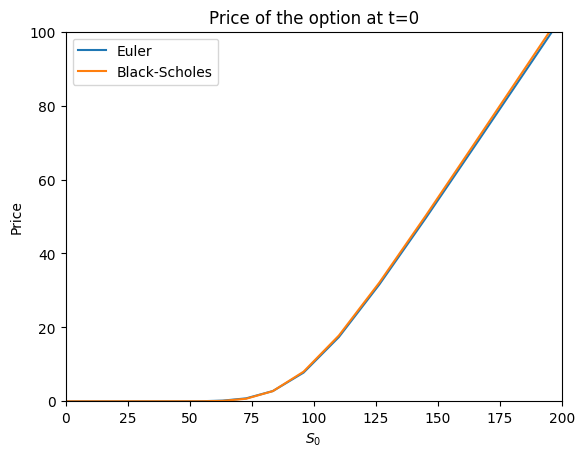

In [13]:
h = 2 * L / N
Uj = euler_explicit_scheme(N, M)

plt.plot(np.exp(np.linspace(-L, L, N - 1)), Uj, label="Euler")
plt.plot(
    np.exp(np.linspace(-L, L, N - 1)),
    black_scholes_price(np.exp(np.linspace(-L, L, N - 1)), K, r, T, sigma),
label="Black-Scholes",
)
plt.title("Price of the option at t=0")
plt.xlabel("$S_0$")
plt.legend()
plt.xlim(0, 200)
plt.ylim(0, 200 - K)
plt.ylabel("Price")

Text(0, 0.5, 'Error')

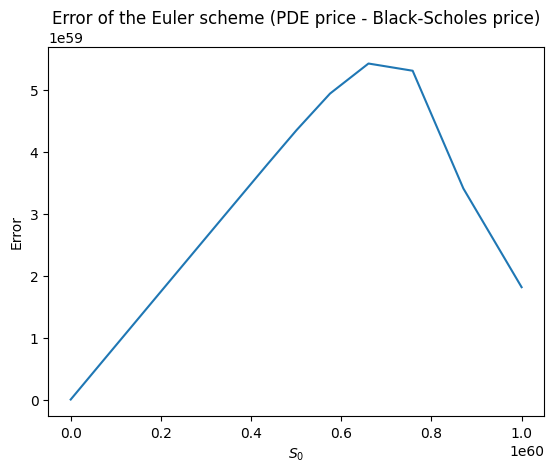

In [14]:
BS_price = black_scholes_price(
        K, T, np.exp(np.linspace(-L, L, N - 1)), r, sigma
    )

plt.plot(
    np.exp(np.linspace(-L, L, N - 1)),
    np.abs(Uj - BS_price),
)

plt.title("Error of the Euler scheme (PDE price - Black-Scholes price)")
plt.xlabel("$S_0$")
plt.ylabel("Error")

- On remarque que les deux prix semblent identiques sur les quelques observations autour de $S_0\simeq 100$, néanmoins les pentes n'ont pas l'air identique ce qui peut entrainer un écart conséquent à grande valeur de $S_0\gg 1$.

## Question 2. 
Tracer l'erreur en norme $\|\cdot\|_\infty$ du vecteur de prix EDP en fonction de N (à M
suffisamment grand fixé). Retrouve-t-on l’ordre de convergence attendu ? Interpréter la
forme de la courbe.

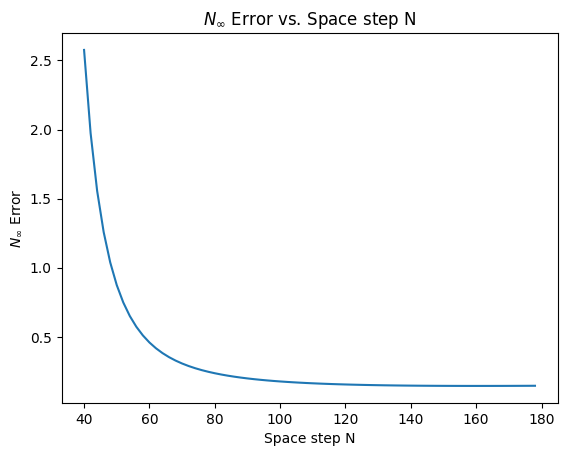

In [33]:
M = 1000
N_range = np.arange(40, 180, 2)

errors = []
for n in N_range:
    h = 2 * L / n
    y = np.array([-L + i * h for i in range(n + 1)])[1:-1]
    BS_prices = black_scholes_price(np.exp(y), K, r, T, sigma)
    edp_prices = euler_explicit_scheme(n, M)
    error = (np.linalg.norm((edp_prices) - BS_prices, np.inf)) / np.linalg.norm(
        BS_prices, np.inf
    )
    errors.append(error)
errors = np.array(errors)
plt.plot(N_range, errors)

plt.title("$N_\infty$ Error vs. Space step N")
plt.xlabel("Space step N")
plt.ylabel("$N_\infty$ Error")

plt.show()

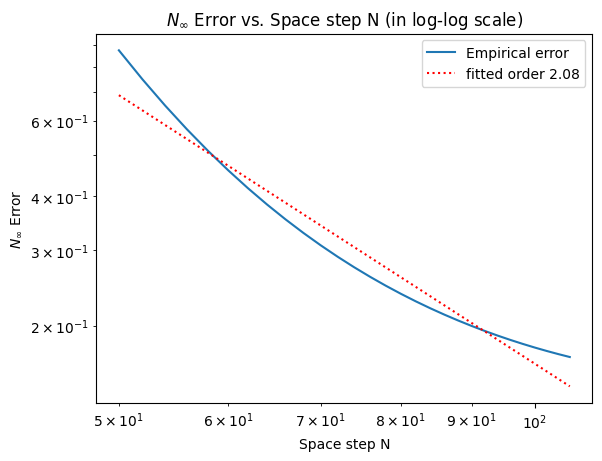

In [34]:
i_min = np.argmax(np.array(errors) < 1)
i_max = np.argmax(np.array(errors) < 1.15 * errors[-1])

coeffs = np.polyfit(np.log(N_range[i_min:i_max]), np.log(errors[i_min:i_max]), 1)

plt.plot(N_range[i_min:i_max], errors[i_min:i_max], "-", label="Empirical error")
plt.plot(
    N_range[i_min:i_max],
    np.exp(coeffs[1]) * N_range[i_min:i_max] ** coeffs[0] ,
    "r:",
    label=f"fitted order {-coeffs[0]:.2f}",
)

plt.title("$N_\infty$ Error vs. Space step N (in log-log scale)")
plt.xlabel("Space step N")
plt.ylabel("$N_\infty$ Error")

plt.xscale("log")
plt.yscale("log")

plt.legend()
plt.show()

On retrouve avec une certaine incertitude le résultat attendu, c'est-à-dire une covergence d'ordre $\simeq 2$ en espace.

## Question 3 
Tracer l'erreur en norme $\|\cdot\|_\infty$ du vecteur de prix EDP en fonction de M (à N suffisamment grand fixé). Retrouve-t-on l’ordre de convergence attendu ? Interpréter la
forme de la courbe.

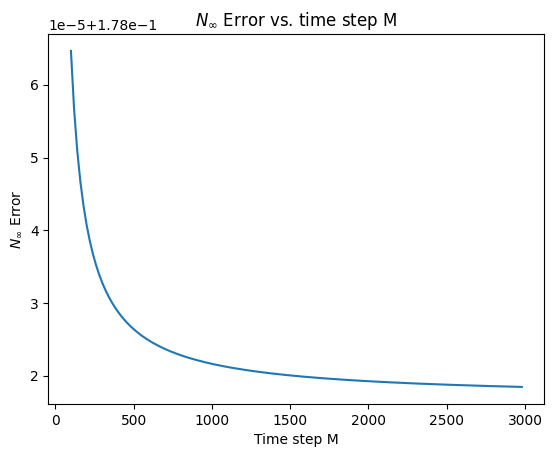

In [ ]:
N = 100
h = 2 * L / N
y = np.array([-L + i * h for i in range(N + 1)])[1:-1]
BS_prices = black_scholes_price(np.exp(y), K, r, T, sigma)
M_range = np.arange(100, 3000, 20)


errors = []
for m in M_range:
    edp_prices = euler_explicit_scheme(N, m)
    error = (np.linalg.norm((edp_prices) - BS_prices, np.inf)) / np.linalg.norm(
        BS_prices, np.inf
    )
    errors.append(error)
errors = np.array(errors)

plt.plot(M_range, errors)
plt.title("$N_\infty$ Error vs. time step M")
plt.xlabel("Time step M")
plt.ylabel("$N_\infty$ Error")
plt.show()

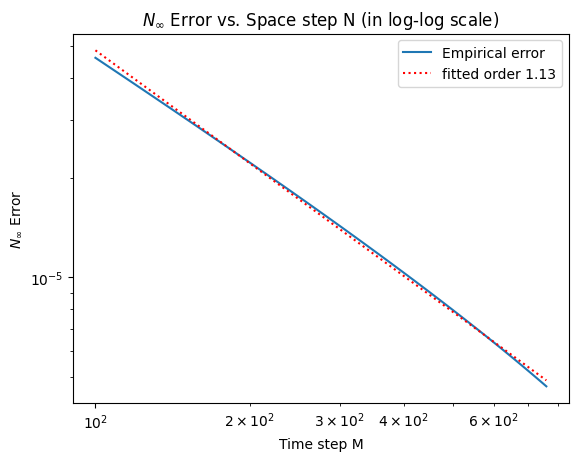

In [ ]:
for i, error in enumerate(errors):
    if error - errors[-1] <= 0.1 * errors[0] - errors[-1]:
        M_max = M_range[i]
        i_max = i
        break

i_min = 0
coeffs = np.polyfit(
    np.log(M_range[i_min:i_max]), np.log(errors[i_min:i_max] - errors[-1]), 1
)

plt.plot(
    M_range[i_min:i_max], errors[i_min:i_max] - errors[-1], "-", label="Empirical error"
)
plt.plot(
    M_range[i_min:i_max],
    np.exp(coeffs[1]) * M_range[i_min:i_max] ** coeffs[0],
    "r:",
    label=f"fitted order {-coeffs[0]:.2f}",
)


plt.title("$N_\infty$ Error vs. Space step N (in log-log scale)")
plt.xlabel("Time step M")
plt.ylabel("$N_\infty$ Error")

plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.show()

L'ordre correspond à celui attendu en terme temporel, c'est-à-dire $\simeq 1$.

## Question 4

Tracer l’erreur ponctuelle $|u^j_i − u(j\Delta T , y_i )|$ en fonction de $t = T − j\Delta T \in [0, T ]$ et $S = e^{y_i} \in [e^{−L}, e^L]$.

In [47]:
def pointwise_error(N, M):
    """
    Compute the pointwise error of the Euler scheme
    parameters:
    - Smax(float): maximum value of the underlying
    - K(float): strike price
    - T(float): maturity
    - sigma(float): volatility
    - r(float): risk-free rate
    - N(int): number of space steps
    - M(int): number of time steps
    Returns:
    - error(float): pointwise error
    """
    delta_T = T / M
    Uij = euler_explicit_scheme(N, M - 1, full_matrix=True)
    y = np.linspace(-L, L, N + 1)[1:-1]
    
    Ubs = np.concatenate(
        [
            black_scholes_price(
                np.exp(y),
                K,
                T - j * delta_T,
                r,
                sigma,
            )
            for j in range(0, M)
        ]
    ).reshape(N - 1, M)
    return (
       np.abs(Uij[:: N // 20, :: M // 20] - Ubs[:: N // 20, :: M // 20]),
        y[:: N // 20],
        np.arange(0, T, T / 20),
    )

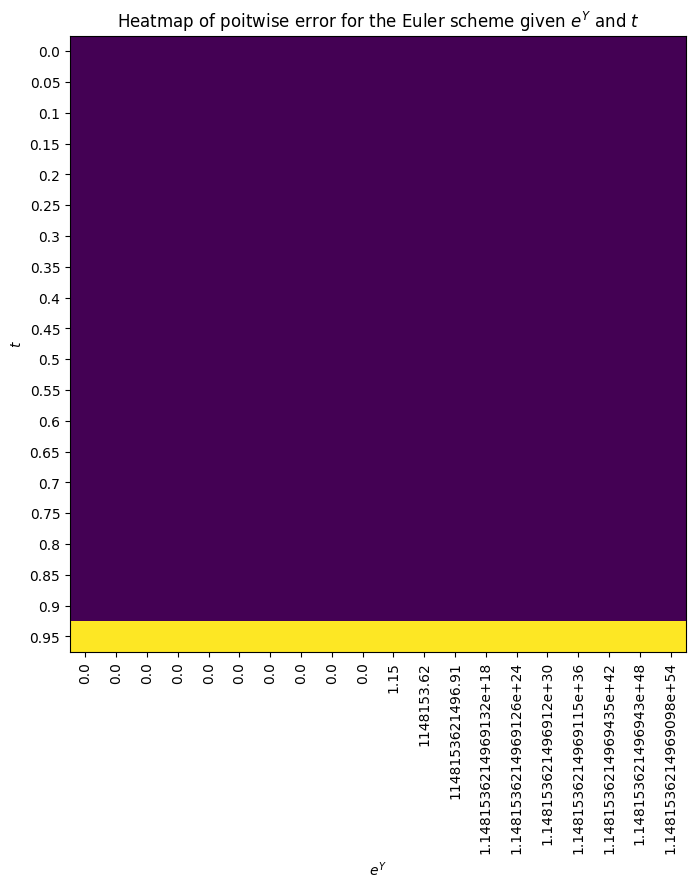

In [48]:
errors, x_range, T_range = pointwise_error(N, M)
plt.figure(figsize=(10, 8))

plt.imshow(errors, cmap="viridis")
plt.xticks(ticks=np.arange(len(x_range)), labels=np.round(np.exp(x_range), 2), rotation=90)
plt.yticks(ticks=np.arange(len(T_range)), labels=np.round(T_range, 2))
plt.title("Heatmap of poitwise error for the Euler scheme given $e^Y$ and $t$")	
plt.xlabel("$e^Y$")
plt.ylabel("$t$")
plt.show()
